In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

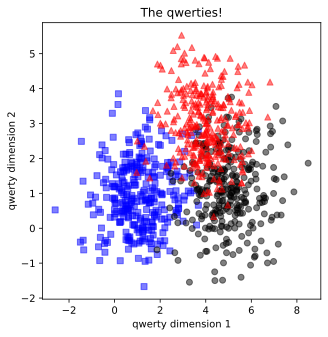

In [5]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]
# [
#   [x₁, x₂, x₃, ..., x₃₀₀],
#   [y₁, y₂, y₃, ..., y₃₀₀]
# ]



# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))
#[0., 0., 0., ..., 0., 1., 1., 1., ..., 1., 2., 2., 2., ..., 2.]

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# [
#   [x₁ₐ, x₂ₐ, ..., x₃₀₀ₐ, x₁_b, ..., x₃₀₀_c],
#   [y₁ₐ, y₂ₐ, ..., y₃₀₀ₐ, y₁_b, ..., y₃₀₀_c]
# ]
 #after transpose ,shape (900, 2)
#Each row = one 2D point and Each column = one coordinate axis

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

#.long() -> Changes the tensor’s data type to torch.int64 (which PyTorch calls “long”).
#This is required when you use nn.CrossEntropyLoss() — it expects labels to be in integer form.

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [6]:
# now we use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=.1)

train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)


batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Creating a Model class


In [10]:
# create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()
  #nn.CrossEntropyLoss() expects raw logits and applies LogSoftmax internally for numerical stability.

  # optimizer -extra param
  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer

In [11]:
optim=createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

How about training the model now? 
Lets do this!

In [23]:
numepochs=50

def function2trainTheModel(momentum):
    net,lossfun,optimizer=createTheQwertyNet(momentum)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]

        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
            # finish of a batch
        #now we have  finished through all the batches in a single epoch, we calculate the average training acuracy 
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)

        net.eval()
        X,y=next(iter(test_loader))
        with torch.no_grad():
            yHat=net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    return trainAcc,testAcc,losses,net
    
    

In [27]:
#experiment
momenta=[0,.5,.9,.95,.999]
# initialize results matrix
results = np.zeros((numepochs,len(momenta),3))

# test all momentum values on the same data (different model instances)
for idx,mom in enumerate(momenta):
  trainAcc,testAcc,losses,net = function2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc

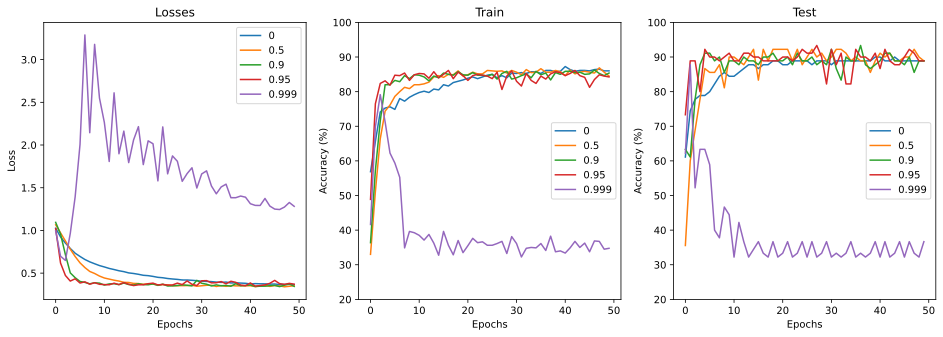

In [28]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()